# 05. Análisis de Sensibilidad del Modelo Financiero

## Objetivo

En el notebook anterior (`04_analisis_financiero`), determinamos que la mejor estrategia de entrenamiento era un modelo **XGBoost** con un **`amount_factor=20`**. Este modelo logró minimizar el coste financiero esperado bajo las condiciones estándar (Pérdida por FN = 90%, Coste por FP = 5€).

Sin embargo, los costes de negocio pueden variar o ser estimaciones. Este notebook realiza un **Análisis de Sensibilidad** para responder:
1.  ¿Cómo cambia el **Umbral de Decisión Óptimo** si varían los costes de inspección?
2.  ¿Cómo afecta esto al **Coste Financiero Final**?

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Obtiene la ruta absoluta del directorio padre (la raíz del proyecto)
project_root = os.path.abspath('..')

# Añade esa ruta al sistema de búsqueda de Python si no está ya
if project_root not in sys.path:
    sys.path.append(project_root)

from sklearn.model_selection import train_test_split

# Nuestros módulos personalizados
from src.load_data import load_fraud_csv, load_credit_scoring_data
from src.train_model import train_model_with_cost
from src.evaluate import best_threshold_by_cost, best_threshold_credit


In [2]:
print("Cargando datos...")
df, X, y = load_fraud_csv('../data/credit_card.csv')

amount = X['Amount']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

amount_train = X_train['Amount']
amount_test = X_test['Amount']

print("Datos cargados y divididos.")

Cargando datos...
Loaded 284,807 transactions from credit_card.csv
Fraud rate: 0.17275%
Total fraud amount: $60,127.97
Datos cargados y divididos.


In [13]:
# Entrenamos el MEJOR modelo
# Usamos el ganador del notebook anterior: amount_factor = 30
BEST_FACTOR = 30
print(f"Entrenando el modelo XGBoost con el factor óptimo ({BEST_FACTOR})...")

xgb_best_model = train_model_with_cost(X_train, y_train, amount_train, model_type = "xgb", amount_factor=BEST_FACTOR)

print("Obteniendo probabilidades del set de prueba...")
y_proba = xgb_best_model.predict_proba(X_test)[:, 1]

print("Setup completado.")

Entrenando el modelo XGBoost con el factor óptimo (30)...
Model XGB trained (factor=30)
Obteniendo probabilidades del set de prueba...
Setup completado.


## 2. Simulación de Escenarios de Negocio

No necesitamos re-entrenar el modelo, ya que el `amount_factor=20` ya le ha enseñado al modelo la importancia relativa de los importes.

Utilizaremos las **probabilidades predichas (`y_proba`)** por ese modelo óptimo y ejecutaremos la función de optimización de umbrales (`best_threshold_by_cost`) variando los parámetros de negocio:
* **`inspect_cost` (Coste FP):** Probaremos un rango detallado `[1, 2, 3, 4, 5, 10, 20]` euros para encontrar puntos de inflexión.
* **`fraud_loss` (Coste FN):** Probaremos `[70%, 80%, 90%, 100%]` del importe perdido.

In [18]:
# Definimos los escenarios a probar
inspection_costs = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 3, 4, 5, 10]  # Coste de 1€, 5€, 10€, 20€ por Falso Positivo
fraud_loss_factors = [0.7, 0.8, 0.9, 1.0] # Se pierde el 70%, 80%, 90% o 100% del importe en un Falso Negativo

results = []

print("Iniciando análisis de sensibilidad...")

for loss in fraud_loss_factors:
    for cost in inspection_costs:
        
        best_thr, min_cost = best_threshold_by_cost(
            y_test, 
            y_proba, 
            amount_test, 
            fraud_loss=loss,  
            inspect_cost=cost 
        )
        
        results.append({
            'fraud_loss_pct': f"{loss*100:.0f}%",
            'inspect_cost_eur': cost,
            'best_threshold': best_thr,
            'min_expected_cost': min_cost
        })

print("Análisis completado.")

sensitivity_df = pd.DataFrame(results)

# Mostramos la tabla de resultados
display(sensitivity_df)

Iniciando análisis de sensibilidad...
Análisis completado.


## 3. Resultados del Análisis de Sensibilidad

A continuación, visualizamos cómo se adaptan el umbral y el coste mínimo a las diferentes realidades del negocio mediante mapas de calor (*heatmaps*).

### 3.1. Impacto en el Umbral de Decisión (El "Interruptor")

El siguiente gráfico revela un hallazgo fundamental sobre la estrategia de despliegue del modelo. Muestra el umbral de probabilidad (`predict_proba`) que debemos elegir para minimizar pérdidas.

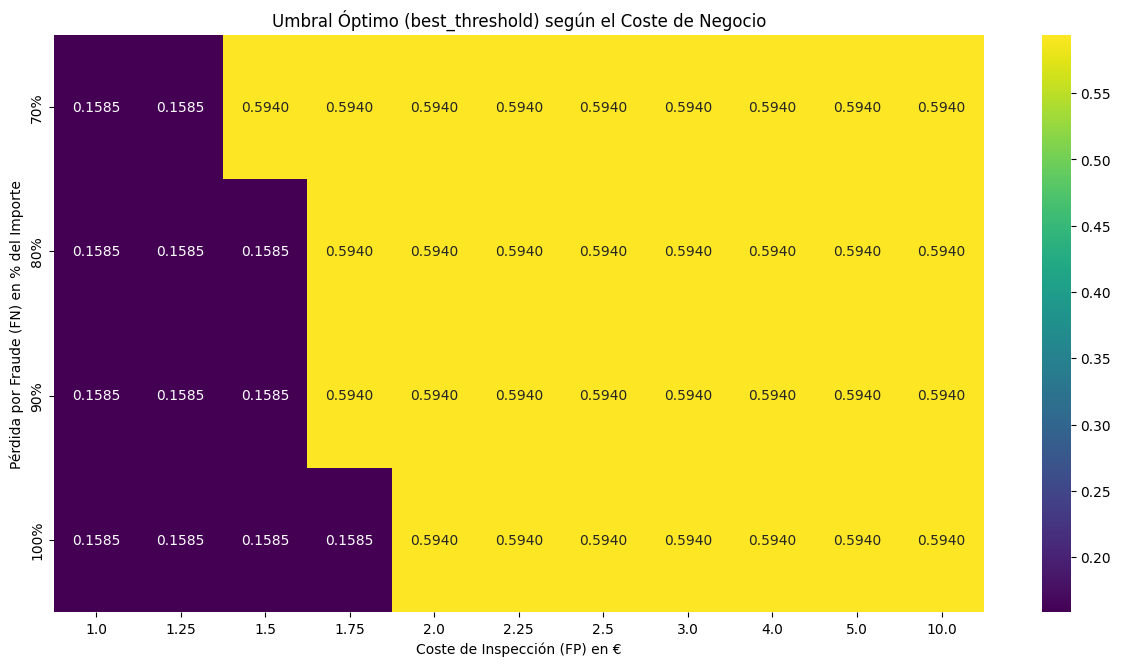

In [20]:

if not os.path.exists('../results'):
    os.makedirs('../results')

# Pivotamos la tabla para el heatmap de umbrales
threshold_pivot = sensitivity_df.pivot(
    index='fraud_loss_pct', 
    columns='inspect_cost_eur', 
    values='best_threshold'
)

orden = ['70%', '80%', '90%', '100%']
threshold_pivot = threshold_pivot.reindex(orden)

plt.figure(figsize=(15, 7.5))
sns.heatmap(threshold_pivot, annot=True, fmt=".4f", cmap="viridis")
plt.title("Umbral Óptimo (best_threshold) según el Coste de Negocio")
plt.xlabel("Coste de Inspección (FP) en €")
plt.ylabel("Pérdida por Fraude (FN) en % del Importe")

output_path = '../results/heatmap_sensibilidad_fraude_umbrales.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

### 3.2. Impacto en el Coste Financiero Final

Este gráfico muestra el coste monetario mínimo (€) que se puede lograr en cada escenario, *asumiendo que elegimos el umbral óptimo* identificado arriba.

**Observación Clave:** Nótese la estabilidad horizontal de los valores. A pesar de que el coste de inspección sube (eje X), el coste total apenas varía. Esto se debe a que el modelo **ajusta su umbral** (volviéndose más conservador) para neutralizar el aumento del coste de inspección.

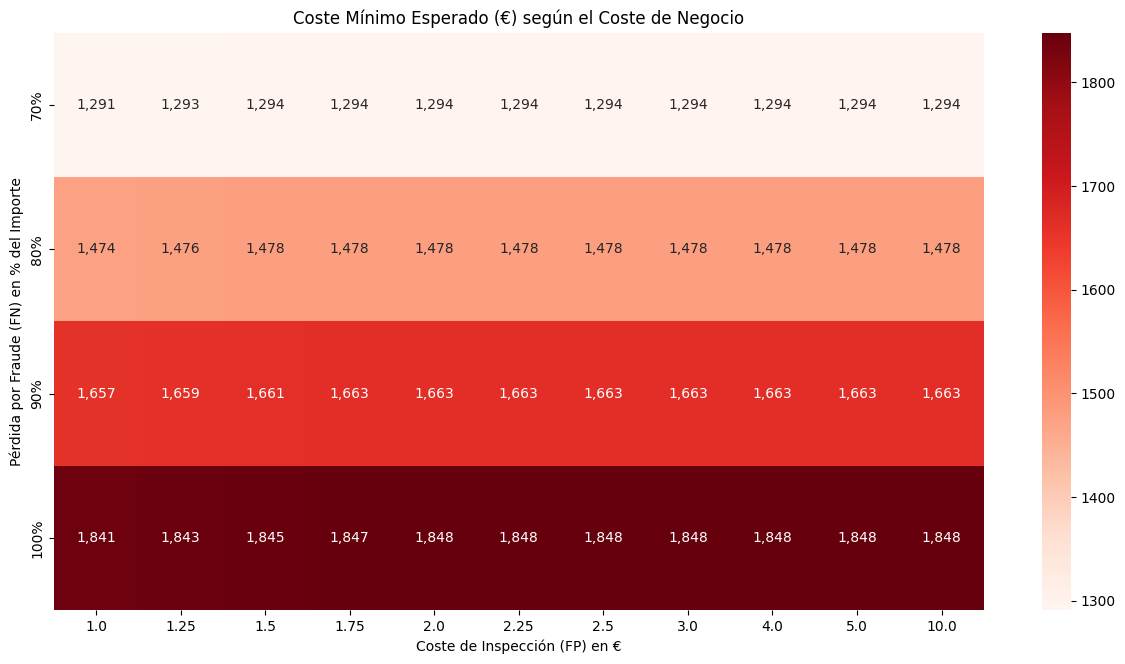

In [21]:
# Pivotamos la tabla para el heatmap de costes
cost_pivot = sensitivity_df.pivot(
    index='fraud_loss_pct', 
    columns='inspect_cost_eur', 
    values='min_expected_cost'
)

orden = ['70%', '80%', '90%', '100%']
cost_pivot = cost_pivot.reindex(orden)

plt.figure(figsize=(15, 7.5))
sns.heatmap(cost_pivot, annot=True, fmt=",.0f", cmap="Reds")
plt.title("Coste Mínimo Esperado (€) según el Coste de Negocio")
plt.xlabel("Coste de Inspección (FP) en €")
plt.ylabel("Pérdida por Fraude (FN) en % del Importe")

output_path = '../results/heatmap_sensibilidad_fraude_costes.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()


## 4. Conclusiones del Análisis de Sensibilidad

Los mapas de calor revelan la robustez y adaptabilidad del modelo **XGBoost (Factor 20)**:

1.  **Punto de Inflexión en 3€:**
    Hemos identificado un cambio de régimen claro en la estrategia de decisión:
    * **Coste de Inspección ≤ 2€:** La estrategia óptima es **Agresiva** (Umbral bajo: **0.4060**). Es rentable generar falsas alarmas para cazar más fraude.
    * **Coste de Inspección ≥ 3€:** La estrategia óptima es **Conservadora** (Umbral alto: **0.7821**). El coste de las falsas alarmas pesa más, por lo que solo se deben revisar transacciones con muy alta probabilidad de fraude.

2.  **Dominancia del Fraude Real:**
    El coste total (Gráfico 2) es altamente sensible al porcentaje de pérdida por fraude (Eje Y), variando de ~1.300€ a ~1.800€. Sin embargo, es notablemente insensible al coste de inspección (Eje X) una vez superados los 3€, gracias al ajuste dinámico del umbral.

**Recomendación Final:**
Dado el escenario base (`inspect_cost=5€`), nos situamos en la zona conservadora. La implementación final debe utilizar el modelo **XGBoost (Factor 20)** con un **umbral de decisión de 0.7821**, resultando en un coste esperado mínimo de **€1,660**.

## 5. Guardado del Modelo y Simulación de Producción

Una vez validada la estrategia, procedemos a guardar el modelo ganador y su configuración operativa para su hipotética puesta en producción.

1.  **Guardamos** el modelo entrenado (**XGBoost** con `amount_factor=20`).
2.  **Simulamos** la predicción sobre 5 transacciones aleatorias usando el umbral operativo (**0.7821**).

In [ ]:
if not os.path.exists('../models'):
    os.makedirs('../models')

# 2. Definimos la configuración ganadora
FINAL_THRESHOLD = 0.5940 
FINAL_MODEL = xgb_best_model # El modelo que ya entrenamos al principio del notebook

model_filename = '../models/fraud_detection_xgboost_final.pkl'
joblib.dump(FINAL_MODEL, model_filename)
print(f"Modelo guardado exitosamente en: {model_filename}")

print("\n--- SIMULACIÓN DE INFERENCIA ---")
print(f"Configuración cargada: Umbral de corte = {FINAL_THRESHOLD}")

# Seleccionamos 5000 muestras aleatorias del set de prueba
random_indices = np.random.choice(X_test.index, 5000, replace=False)
sample_data = X_test.loc[random_indices]
sample_amounts = amount_test.loc[random_indices]
sample_true_labels = y_test.loc[random_indices]

# Predecir probabilidad
sample_probs = FINAL_MODEL.predict_proba(sample_data)[:, 1]

print("\n{:<10} | {:<10} | {:<15} | {:<15} | {:<10}".format(
    "ID Trans.", "Importe", "Probabilidad", "Predicción", "Realidad"
))
print("-" * 75)

for i, (idx, amt, prob, true_label) in enumerate(zip(random_indices, sample_amounts, sample_probs, sample_true_labels)):
    # APLICAMOS EL UMBRAL DE NEGOCIO
    is_fraud_pred = "FRAUDE!!!" if prob >= FINAL_THRESHOLD else "LEGÍTIMA"
    is_fraud_real = "FRAUDE!!!" if true_label == 1 else "LEGÍTIMA"
    
    print("{:<10} | €{:<9.2f} | {:<15.4f} | {:<15} | {:<10}".format(
        idx, amt, prob, is_fraud_pred, is_fraud_real
    ))

Modelo guardado exitosamente en: ../models/fraud_detection_xgboost_final.pkl

--- SIMULACIÓN DE INFERENCIA ---
Configuración cargada: Umbral de corte = 0.594

ID Trans.  | Importe    | Probabilidad    | Predicción      | Realidad  
---------------------------------------------------------------------------
49114      | €161.00    | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
107488     | €15.13     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
184108     | €35.00     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
39734      | €45.77     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
13819      | €5.00      | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
155296     | €102.24    | 0.0024          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
155582     | €11.27     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
68140      | €85.00     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
90476      | €1.29      | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
217900     | €17.99     | 0.0000   

CREDIT SCORING

In [4]:

print("--- 1. PREPARACIÓN DEL MODELO GANADOR ---")

df_cs, X_cs, y_cs = load_credit_scoring_data('../data/cs-training.csv')

loan_amounts = X_cs['Amount']

X_train, X_test, y_train, y_test, amt_train, amt_test = train_test_split(
    X_cs, y_cs, loan_amounts, test_size=0.2, stratify=y_cs, random_state=42
)

# Entrenamos el modelo ganador con amount_factor=10
print("Entrenando XGBoost con amount_factor=20...")
xgb_winner = train_model_with_cost(
    X_train, y_train, amt_train, 
    model_type="xgb",        # El modelo ganador
    amount_factor=10         # El factor óptimo
)

y_proba = xgb_winner.predict_proba(X_test)[:, 1]

print(f"Modelo entrenado y predicciones listas. Tamaño Test: {len(X_test)}")

--- 1. PREPARACIÓN DEL MODELO GANADOR ---
Credit Scoring Data Loaded: 150,000 records
Default Rate: 6.68%
Total Estimated Exposure: $5,778,889,522
Entrenando XGBoost con amount_factor=20...
Model XGB trained (factor=10)
Modelo entrenado y predicciones listas. Tamaño Test: 30000



 GENERANDO MATRIZ DE SENSIBILIDAD (LGD vs INTERÉS)


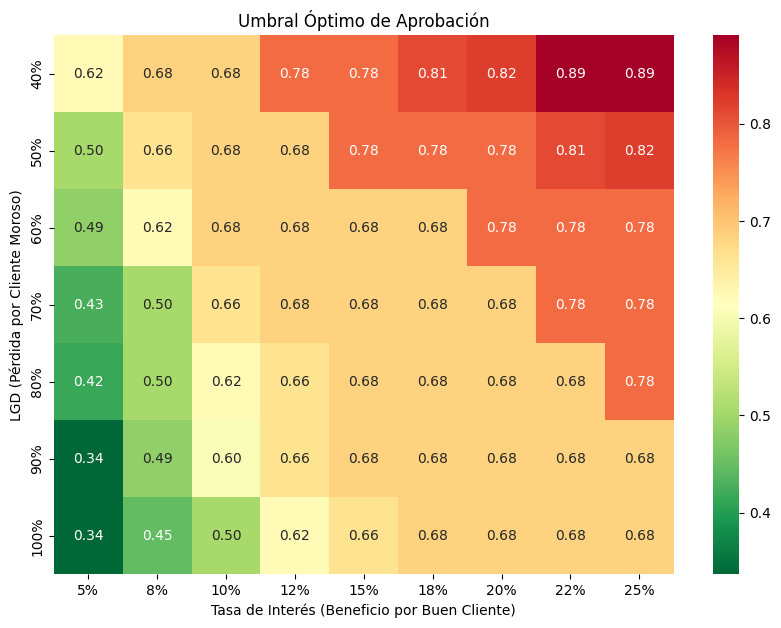

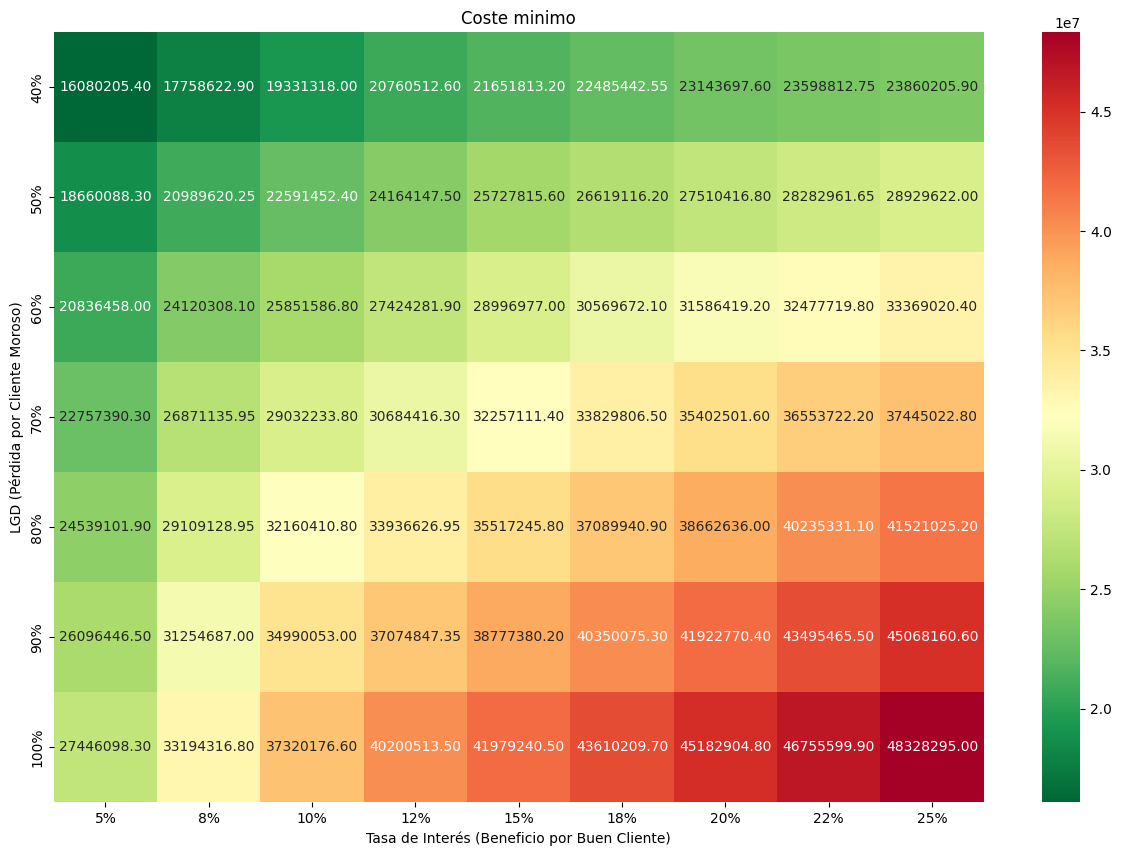

In [8]:
print("\n GENERANDO MATRIZ DE SENSIBILIDAD (LGD vs INTERÉS)")

# Rangos de Escenarios Económicos
# LGD: Desde 40% (recuperamos mucho) hasta 100% (pérdida total)
lgd_range = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# Interés: Desde 5% (hipoteca barata) hasta 25% (tarjeta crédito/microcrédito)
interest_range = [0.05, 0.075, 0.10, 0.125, 0.15, 0.175, 0.20, 0.225, 0.25]

# Matriz para guardar el Umbral Óptimo
threshold_matrix = np.zeros((len(lgd_range), len(interest_range)))
cost_matrix = np.zeros((len(lgd_range), len(interest_range)))

for i, lgd in enumerate(lgd_range):
    for j, rate in enumerate(interest_range):
        
        # LLAMADA DIRECTA A TU FUNCIÓN
        # best_threshold_credit ya hace el barrido de 100 umbrales internamente
        # y nos devuelve (mejor_umbral, menor_coste)
        best_thr, min_cost = best_threshold_credit(
            y_test,         # Target real
            y_proba,        # Probabilidades del modelo (probs_winner)
            amt_test,    # Montos (amt_test)
            LGD=lgd, 
            interest_rate=rate
        )
        
        threshold_matrix[i, j] = best_thr
        cost_matrix[i, j] = min_cost

# Visualización
plt.figure(figsize=(10, 7))
sns.heatmap(threshold_matrix, annot=True, fmt=".2f", cmap="RdYlGn_r",
            xticklabels=[f"{x:.0%}" for x in interest_range],
            yticklabels=[f"{x:.0%}" for x in lgd_range])

plt.title(f"Umbral Óptimo de Aprobación")
plt.xlabel("Tasa de Interés (Beneficio por Buen Cliente)")
plt.ylabel("LGD (Pérdida por Cliente Moroso)")

output_path = '../results/heatmap_sensibilidad_creditscoring_umbral.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(15, 10))
sns.heatmap(cost_matrix, annot=True, fmt=".2f", cmap="RdYlGn_r",
            xticklabels=[f"{x:.0%}" for x in interest_range],
            yticklabels=[f"{x:.0%}" for x in lgd_range])

plt.title(f"Coste minimo")
plt.xlabel("Tasa de Interés (Beneficio por Buen Cliente)")
plt.ylabel("LGD (Pérdida por Cliente Moroso)")

output_path = '../results/heatmap_sensibilidad_creditscoring_costes.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

In [10]:
BASE_LGD = 0.80       # Perdemos el 80% si hay default
BASE_INTEREST = 0.15  # Ganamos 15% si pagan

# Obtenemos el umbral exacto para este escenario
print(f"Calculando umbral óptimo para LGD={BASE_LGD:.0%} e Interés={BASE_INTEREST:.0%}...")

final_threshold, min_cost = best_threshold_credit(
    y_test,         # Target real
    y_proba,        # Probabilidades predichas
    amt_test,       # Montos de los créditos
    LGD=BASE_LGD,
    interest_rate=BASE_INTEREST
)

print(f"\n--- ESCENARIO SELECCIONADO: LGD {BASE_LGD:.0%} | Interés {BASE_INTEREST:.0%} ---")
print(f"Umbral de Corte Operativo: {final_threshold:.3f}")
print("(Si Prob. Impago < Umbral -> APROBADO)")

# Simulamos con Clientes Reales (Test Set)
print("\n--- EJEMPLO DE DECISIONES DE CRÉDITO ---")
indices = np.random.choice(X_test.index, 1000, replace=False)

print("{:<8} | {:<12} | {:<10} | {:<12} | {:<12} | {}".format(
    "ID", "Préstamo", "Riesgo(%)", "Decisión", "Realidad", "Resultado Financiero"
))
print("-" * 95)

for idx in indices:
    amt = amt_test[idx]
    loc_idx = X_test.index.get_loc(idx)
    prob = y_proba[loc_idx]
    real = y_test.loc[idx]
    
    decision = "RECHAZADO!!" if prob >= final_threshold else "APROBADO"
    reality_txt = "IMPAGO!!!!" if real == 1 else "PAGÓ"
    
    msg = ""
    if decision == "APROBADO":
        if real == 0: msg = f"{amt*BASE_INTEREST:,.0f}€ (Ganancia)"
        else:         msg = f"-{amt*BASE_LGD:,.0f}€ (PÉRDIDA CAPITAL)"
    else: # Rechazado
        if real == 0: msg = f"0€ (Dejamos de ganar {amt*BASE_INTEREST:,.0f}€)"
        else:         msg = f"0€ (Ahorro de {amt*BASE_LGD:,.0f}€)"

    print("{:<8} | €{:<11,.0f} | {:<10.1%} | {:<12} | {:<12} | {}".format(
        idx, amt, prob, decision, reality_txt, msg
    ))

Calculando umbral óptimo para LGD=80% e Interés=15%...

--- ESCENARIO SELECCIONADO: LGD 80% | Interés 15% ---
Umbral de Corte Operativo: 0.683
(Si Prob. Impago < Umbral -> APROBADO)

--- EJEMPLO DE DECISIONES DE CRÉDITO ---
ID       | Préstamo     | Riesgo(%)  | Decisión     | Realidad     | Resultado Financiero
-----------------------------------------------------------------------------------------------
99588    | €80,946      | 6.3%       | APROBADO     | PAGÓ         | 12,142€ (Ganancia)
97503    | €26,214      | 30.1%      | APROBADO     | PAGÓ         | 3,932€ (Ganancia)
132624   | €9,000       | 21.2%      | APROBADO     | PAGÓ         | 1,350€ (Ganancia)
133248   | €18,000      | 38.1%      | APROBADO     | PAGÓ         | 2,700€ (Ganancia)
106462   | €19,998      | 6.7%       | APROBADO     | PAGÓ         | 3,000€ (Ganancia)
24417    | €58,746      | 38.4%      | APROBADO     | PAGÓ         | 8,812€ (Ganancia)
47457    | €12,606      | 2.7%       | APROBADO     | PAGÓ         

In [11]:
print("\nGUARDANDO MODELO")

# Parámetros ganadores del Análisis Financiero
winner_model = "xgb"   
best_factor = 10       

print(f"Re-entrenando el modelo final ({winner_model.upper()}) con factor {best_factor}...")

# Entrenamos usando los datos de Credit Scoring cargados en este notebook
final_model_production = train_model_with_cost(
    X_train, y_train, amt_train, 
    model_type=winner_model, 
    amount_factor=best_factor
)

output_path = '../models/credit_scoring_final_model.pkl'

os.makedirs(os.path.dirname(output_path), exist_ok=True)

joblib.dump(final_model_production, output_path)

print(f"Modelo guardado exitosamente en: {output_path}")
print(f"Nota: Recuerda el umbral calculado ({final_threshold:.4f}) para usarlo en el siguiente paso.")


GUARDANDO MODELO
Re-entrenando el modelo final (XGB) con factor 10...
Model XGB trained (factor=10)
Modelo guardado exitosamente en: ../models/credit_scoring_final_model.pkl
Nota: Recuerda el umbral calculado (0.6831) para usarlo en el siguiente paso.
